# [NTDS'19] assignment 1: network science
[ntds'19]: https://github.com/mdeff/ntds_2019

[Clément Vignac](https://people.epfl.ch/clement.vignac), [EPFL LTS4](https://lts4.epfl.ch) and
[Guillermo Ortiz Jiménez](https://gortizji.github.io), [EPFL LTS4](https://lts4.epfl.ch).

## Students

* Team: `<your team number>`
* Students: `<your name`> (for the indivudual submission) or `<the name of all students in the team>` (for the team submission)

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

*To be completed*

# Graph Signal Processing

In this part of the assignment we are going to familiarize ourselves with the main concepts in Graph Signal Processing. 

You can only use the following libraries for this part of the assignment.

In [261]:
from pygsp import graphs
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
%matplotlib inline

We start by importing the graph that will serve as support for our signals. In this exercise we will use a nearest-neighbor graph constructed from the Stanford Bunny point cloud included in the PyGSP library.

In [173]:
G = graphs.Bunny()
adjacency = np.asarray(G.W.todense())
n_nodes = adjacency.shape[0]

In [174]:
def plot_bunny(signal=None,title=''):
    fig = plt.gcf()
    ax = plt.gca()
    if not isinstance(ax, Axes3D):
        ax = plt.subplot(111, projection='3d')
    if signal is not None:
        signal = np.squeeze(signal)
    p = ax.scatter(G.coords[:,0], G.coords[:,1], G.coords[:,2], c=signal, marker='o', s=5, cmap='RdBu_r')
    ax.view_init(elev=-90,azim=90)
    ax.dist = 7
    ax.set_axis_off()
    ax.set_title(title)
    if signal is not None:
        fig.colorbar(p)

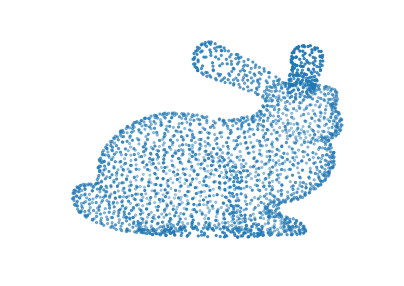

In [175]:
plt.subplot(111,projection='3d')
plot_bunny()

## Exercise 1

Let us start by constructing the normalized graph laplacian from an adjacency matrix 

In [212]:
def normalized_laplacian(adjacency):
    D = np.diag(np.sum(adjacency, 1)) # Degree matrix
    D_norm = np.diag(np.sum(adjacency, 1)**(-1/2)) 
    laplacian_combinatorial =  D - adjacency
    return D_norm @ laplacian_combinatorial @ D_norm

In [213]:
laplacian = normalized_laplacian(adjacency)

## Exercise 2

Find the spectral decomposition of the laplacian. Make sure that the eigenvalues and eigenvectors are in increasing order $\lambda_0\leq \lambda_1\leq \dots \leq \lambda_n$

In [178]:
e, U = np.linalg.eigh(laplacian)
U = np.asarray(U)

Plot the eigenvalues

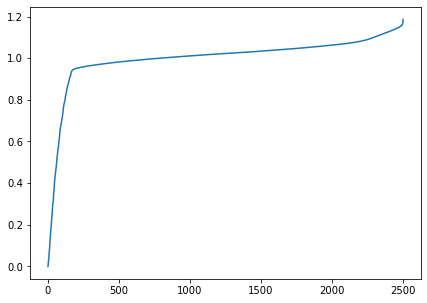

In [179]:
plt.plot(e)

What do you observe?

To make things more clear we will plot some eigenvectors (0, 1, 3, 10, 100) of the laplacian as signals on the bunny graph.

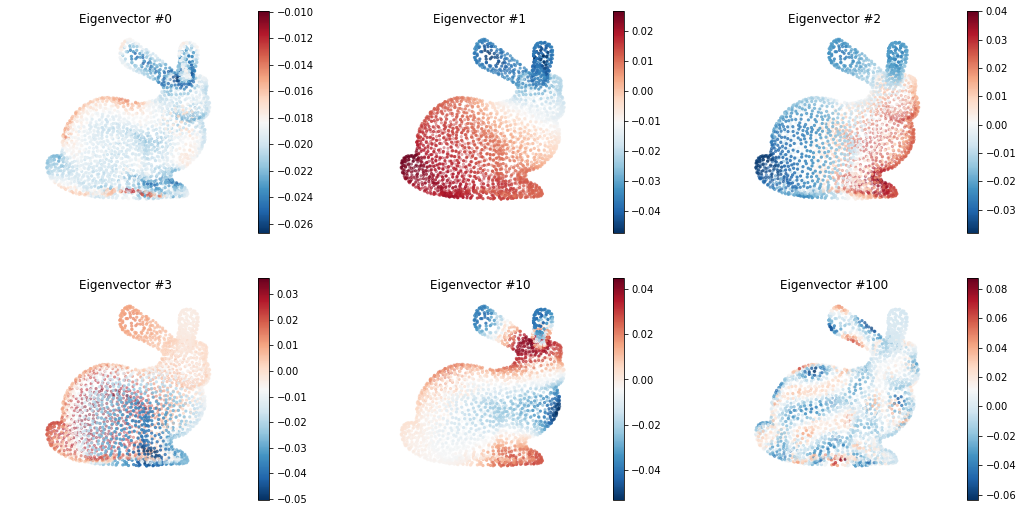

In [180]:
plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(signal=U[:,0], title='Eigenvector #0')
plt.subplot(232, projection='3d')
plot_bunny(signal=U[:,1], title='Eigenvector #1')
plt.subplot(233, projection='3d')
plot_bunny(signal=U[:,2], title='Eigenvector #2')

plt.subplot(234, projection='3d')
plot_bunny(signal=U[:,3], title='Eigenvector #3')
plt.subplot(235, projection='3d')
plot_bunny(signal=U[:,10], title='Eigenvector #10')
plt.subplot(236, projection='3d')
plot_bunny(signal=U[:,100], title='Eigenvector #100')

What can you say in terms of the variations/smoothness of these signals

## Exercise 3

Create a function to compute the Graph Fourier Transform and its inverse of a graph signal

In [181]:
def GFT(x):
    return U.T @ x

def iGFT(x):
    return U @ x

Now, create an all-pass graph signal

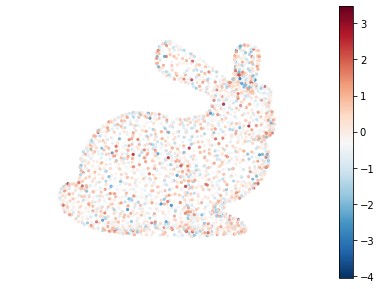

In [182]:
signal = iGFT(np.ones([n_nodes, 1]))
plot_bunny(signal)

Plot its graph spectrum

<StemContainer object of 3 artists>

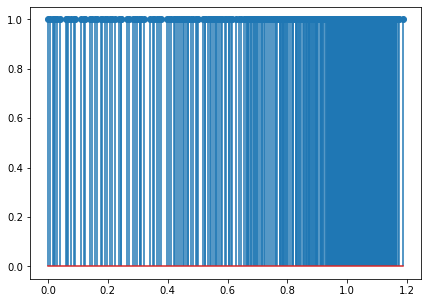

In [183]:
plt.stem(e, GFT(signal), use_line_collection=True)

We will filter this signal using spectral templates. Let us start by creating three templates

In [184]:
template_lp = np.ones(signal.shape)
template_bp = np.ones(signal.shape)
template_hp = np.ones(signal.shape)

template_lp[e >= 0.1] = 0 # Low-pass filter with cut-off at lambda=0.1
template_bp[e < 0.1] = 0 # Band-pass filter with cut-offs at lambda=0.1 and lambda=0.5
template_bp[e > 0.5] = 0
template_hp[e <= 1] = 0 # High-pass filter with cut-off at lambda=1

Create a function to filter a signal given a specific spectral template

In [185]:
def template_graph_filter(signal, template):
    signal_gft = GFT(signal)
    filter_gft = signal_gft * template
    return iGFT(filter_gft)

Let us visualize the results

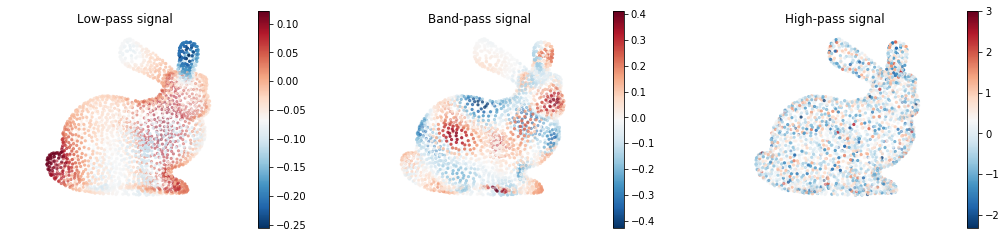

In [186]:
signal_lp = template_graph_filter(signal,template_lp)
signal_bp = template_graph_filter(signal,template_bp)
signal_hp = template_graph_filter(signal,template_hp)

plt.figure(figsize=(18, 4))
plt.subplot(131, projection='3d')
plot_bunny(signal=signal_lp, title='Low-pass signal')
plt.subplot(132, projection='3d')
plot_bunny(signal=signal_bp, title='Band-pass signal')
plt.subplot(133, projection='3d')
plot_bunny(signal=signal_hp, title='High-pass signal')

What can you say in terms of the signal variations?

## Exercise 4

We have seen how we can use the GFT to define different filters that enhance or reduce certain frequency bands. However, to do so, we require an explicit eigendecomposition of the graph laplacian. For very large graphs this is very intense computationally. We will now see how we can obtain similar results by filtering the signals directly in the vertex domain.

The key idea is to use a polynomial of the graph laplacian to define a graph filter, i.e., $g(L)x=\sum_{k=1}^K \alpha_k L^k x$, and use the fact that the powers of a diagonalizable matrix can be written in terms of powers of its eigenvalues. This is
$$
\begin{equation}
        L^k=(U\Lambda U^T)^k=U\Lambda^k U^T = U\begin{bmatrix}
        \lambda_0^k &\dots & 0\\
        \vdots & \ddots & \vdots\\
        0 & \dots & \lambda_N
        \end{bmatrix} U^T
    \end{equation}
$$

This means, that a polynomial of the graph laplacian acts independently on each eigenvalue of the graph, and has a frequency spectrum of
$$g(\lambda)=\sum_{k=1}^K \alpha_k \lambda^k$$
Hence,
$$g(L)x=\sum_{k=1}^K \alpha_k L^k x=\sum_{k=1}^K \alpha_k U\Lambda^k U^T x=U \left(\sum_{k=1}^K \alpha_k\Lambda^k \right)U^T x=\operatorname{iGFT}\left(g(\Lambda)\operatorname{GFT}(x)\right)$$


With these ingredients, we have reduced the design of graph filters in the vertex domain to a regression task that approximates a given spectral response by a polynomial. There are multiple ways to do this, but in this assignment we will implement a very simple strategy based on [least-squares regression](https://en.wikipedia.org/wiki/Polynomial_regression#Matrix_form_and_calculation_of_estimates).

Let us create a band-pass universal spectral template

In [187]:
freq_grid = np.linspace(0,2, 200)

template_bp = np.ones(freq_grid.shape)
template_bp[freq_grid < 0.1] = 0
template_bp[freq_grid >= 0.5] = 0

Implement a function to find the coefficients of a polynomial that approximates a given spectral template. **Hint:** `np.vander` and `np.linalg.lstsq`

In [188]:
def fit_polynomial(freq_grid, order, template):
    A = np.vander(freq_grid, order, increasing=True)
    coeff = np.linalg.lstsq(A, template, rcond=None)[0]
    return coeff

Implement a function to compute the frequency response of that filter

In [189]:
def fir_graph_filter_response(coeff, freq_grid):
    g = np.zeros_like(freq_grid)
    for n, c in enumerate(coeff):
        g += c * (freq_grid**n)
    return g

Let us fit the band-pass template with several polynomials of different order

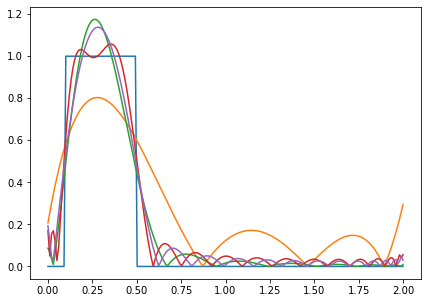

In [190]:
plt.plot(freq_grid, template_bp)
for order in [5, 10, 20, 30]:    
    coeff_bp = fit_polynomial(freq_grid, order, template_bp)
    plt.plot(freq_grid, np.abs(fir_graph_filter_response(coeff_bp, freq_grid)))

Based on the previous plot, choose a filter order that achieves (in your opinion) a good tradeoff in terms of computational complexity and response accuracy.

In [191]:
order = 10

In [192]:
coeff_bp = fit_polynomial(freq_grid, order, template_bp)

So far, we have only defined a way to compute the coefficients of our laplacian polynomial. Let us now compute our graph filter.

In [193]:
def fir_graph_filter(coeff, laplacian):
    g = 0
    for n, c in enumerate(coeff):
        g += c * np.linalg.matrix_power(laplacian, n)
    return g

In [194]:
g_bp = fir_graph_filter(coeff_bp, laplacian)

Filter the previous all-pass signal with this filter

In [195]:
signal_bp_fir = g_bp @ signal

Let us compare with the previous version

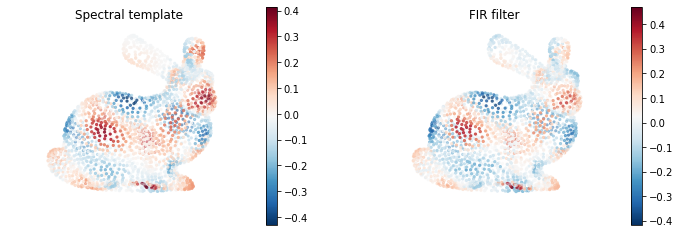

In [196]:
plt.figure(figsize=(12, 4))
plt.subplot(121, projection='3d')
plot_bunny(signal_bp, title='Spectral template')
plt.subplot(122, projection='3d')
plot_bunny(signal_bp_fir, title='FIR filter')

To better compare these signals, let us plot their spectrums

<StemContainer object of 3 artists>

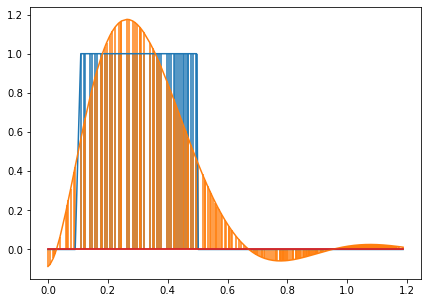

In [197]:
plt.stem(e, GFT(signal_bp), use_line_collection=True, linefmt='C0', markerfmt='C0')
plt.stem(e, GFT(signal_bp_fir), use_line_collection=True, linefmt='C1', markerfmt='C1')

## Exercise 5

So far, we have only played with toy examples. Let us see the use of these tools in practice! In particular, let us see how we can use some graph filters to construct features to feed a classifier.

We will use the CORA dataset and the citation graph that we created in Assignment 1.

In [206]:
cora_cites = np.genfromtxt('data/cora/cora.cites', delimiter='\t')
# get graph edges and flatten them for processing
edges = cora_cites.astype(int)
edges = edges.flatten()

# get adjacency matrix from edge_list
newedge = pd.factorize(edges)[0]
new_edge_list = newedge.reshape(-1, 2)
dim = max(newedge) + 1
adjmat = np.zeros((dim, dim))
adjmat[new_edge_list[:, 0], new_edge_list[:, 1]] = 1

# caution, matrix is not symmetric at this point 
A_citation = adjmat
A_citation = A_citation + A_citation.T

In [214]:
laplacian = normalized_laplacian(A_citation)

Construct three graph filters (low-pass, band-pass, high-pass). Feel free to choose the order and cut-off frequencies as you like.

In [378]:
order = 3

template_lp_fir = np.ones(freq_grid.shape)
template_bp_fir = np.ones(freq_grid.shape)
template_hp_fir = np.ones(freq_grid.shape)

template_lp_fir[freq_grid >= 1.2] = 0 # Low-pass filter with cut-off at lambda=0.1
template_bp_fir[freq_grid < 0.5] = 0 # Band-pass filter with cut-offs at lambda=0.1 and lambda=0.5
template_bp_fir[freq_grid > 1] = 0
template_hp_fir[freq_grid <= 1] = 0 # High-pass filter with cut-off at lambda=1

In [379]:
coeff_lp = fit_polynomial(freq_grid, order, template_lp_fir)
coeff_bp = fit_polynomial(freq_grid, order, template_bp_fir)
coeff_hp = fit_polynomial(freq_grid, order, template_hp_fir)


g_lp = fir_graph_filter(coeff_lp, laplacian)
g_bp = fir_graph_filter(coeff_bp, laplacian)
g_hp = fir_graph_filter(coeff_hp, laplacian)

In this assignment, we will interpret CORA's features as graph signals living on the citation graph.

Construct three versions of the features, each filtered by one of the filters

In [386]:
feature_list = list(range(1,1434))
column_list = ['paper_id'] + feature_list + ['class_label']
pd_content = pd.read_csv('data/cora/cora.content', delimiter='\t', names=column_list) 

In [387]:
X = pd_content.iloc[:, 1:1434]
y = pd_content['class_label']

In [388]:
X_lp = g_lp @ X
X_bp = g_bp @ X
X_hp = g_hp @ X

Let us choose a few nodes and train a logistic classifier on the remaining ones.

In [395]:
node_mask = np.random.choice(2703, 140, replace=False)

In [396]:
from sklearn.linear_model import LogisticRegression

lr_lp = LogisticRegression()
lr_bp = LogisticRegression()
lr_hp = LogisticRegression()
lr = LogisticRegression()

score = []
for clf, data in zip([lr_lp, lr_bp, lr_hp, lr], [X_lp, X_bp, X_hp, X]):
    clf.fit(data.iloc[node_mask,:], y[node_mask])
    score.append(clf.score(data.loc[~data.index.isin(node_mask)],y[~data.index.isin(node_mask)]))

In [397]:
score

[0.4606697819314642,
 0.3781152647975078,
 0.42562305295950154,
 0.5533489096573209]